In [1]:
import numpy as np
import IPython
from IPython.display import HTML
import pickle
import tensorflow as tf

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 17})

In [40]:
class Regression:
    def __init__(self, _hSize):
        dictToOpen = "Data" + "/Dict.txt"
        with open(dictToOpen, "rb") as myFile:
            Dict_processed_data = pickle.load(myFile)
        
        self.pMin = Dict_processed_data['paraMin']
        self.pMax = Dict_processed_data['paraMax'] 
        self.oMin = Dict_processed_data['obserMin'] 
        self.oMax = Dict_processed_data['obserMax']
        self.rProf = np.asarray(Dict_processed_data['rProf'])
        self.hSize = _hSize
        self.x1 = resultsDict["x1"]
        self.y1 = resultsDict["y1"]
        self.x0 = resultsDict["x0"]
        self.y0 = resultsDict["y0"]
        
    def NN(self, _parameters, _NEPOCH=1, _learnRate=1, _keepProb=1):
        tf.reset_default_graph()
        hSize = self.hSize
        NEPOCH = _NEPOCH
        learnRate = _learnRate
        keepProb = _keepProb
        parameters = _parameters
        xSize = self.x1
        yNumParameters = self.y1
        ySize = 1
        STDEV = 0.1
        
        #Xavier initialization
        def getW(in_dim, out_dim):
            xavier_stddev = np.sqrt(2/(in_dim + out_dim))
            return tf.Variable(tf.random_normal([in_dim, out_dim], stddev=xavier_stddev, dtype=tf.float64), \
                               dtype=tf.float64)
        
        # set up parameters
        W = []
        b = []
        layer = []
        layer_train = []
        lambd = tf.placeholder(dtype=tf.float64, shape=(), name="lambd")
        x = tf.placeholder(dtype=tf.float64, shape=[None,xSize], name="x")
        y = tf.placeholder(dtype=tf.float64, shape=[None,yNumParameters], name="y")
        # first layer#
        W.append(getW(xSize, hSize[0]))
        b.append(tf.Variable(tf.random_normal([1,hSize[0]], stddev=STDEV, dtype=tf.float64)))
        # add hidden layers (variable number)
        for i in range(1,len(hSize)):
            W.append(getW(hSize[i-1], hSize[i]))
            b.append(tf.Variable(tf.random_normal([1,hSize[i]], stddev=STDEV, dtype=tf.float64)))
        # add final layer
        W.append(getW(hSize[-1], ySize * yNumParameters))
        b.append(tf.Variable(tf.random_normal([1,ySize * yNumParameters], stddev=STDEV, dtype=tf.float64)))
        # define model
        keep_prob = tf.placeholder(dtype=tf.float64)
        layer.append(tf.nn.tanh(tf.matmul(x, W[0]) + b[0]))
        for i in range(1,len(hSize)):
            layer.append(tf.nn.dropout(tf.nn.tanh(tf.matmul(layer[i-1], W[i]) + b[i]),keep_prob))
        y_out = tf.matmul(layer[-1],W[-1]) + b[-1]
        
        l2_regularization = [tf.nn.l2_loss(w) for w in W]
        lossfunc = tf.reduce_mean(tf.squared_difference(y_out,y)) + tf.add_n(l2_regularization)*lambd
        train_op = tf.train.AdamOptimizer(learning_rate=learnRate).minimize(lossfunc)
        
        ################################ Load the session #######################################################
        sess = tf.InteractiveSession()
        saver = tf.train.Saver()
        strNetwork = str([str(hSize[i]) for i in range(np.size(hSize))])
        str2 = strNetwork.replace(',','').replace("'","").replace(' ', '').replace('[','').replace(']','')
        saver.restore(sess, "Data/Session_Wi" + str2)
        lambdVal = 0.0001/self.x0
        
        def normalize(d, dMax, dMin):
            return (d-dMin)/(dMax-dMin)
        
        def dimensionalize(d, dMax, dMin):
            return (d*(dMax-dMin))+dMin
        
        # Dimensional parameters
        year_to_seconds = 365.25 * 24. * 3600.
        T_delta = 2000.
        rho_m  = 3500. 
        g = 3.7
        k_m = 4.
        r_m = 1700e+3
        r_c = 1700e+3
        alpha_m = 2.5e-5
        k_diffusive = 1e-6 
        
        def dimensionalizeTime(t):
            return t/k_diffusive*np.power(r_m,2.)/year_to_seconds
        
        def displayColorVec(vecInterest):
            vecInterestTemp = vecInterest 
            vecInterest = np.interp(vecInterest, (vecInterest.min(), vecInterest.max()), (0, 1))
            figc, axc = plt.subplots(figsize=(3,0.1), dpi=320)
            gradient= np.sort(vecInterest)
            gradient = np.vstack((gradient, gradient))
            axc.imshow(gradient, aspect='auto', cmap=plt.get_cmap('jet'))
            axc.set_xlabel('time $[Gyr]$')
            axc.set_yticklabels([])
            axc.set_yticks([])
            my_xticks = axc.get_xticks()    
            plt.xticks([my_xticks[1], my_xticks[-1]],['{:.2}'.format(min(vecInterestTemp)), \
                    '{:.2}'.format(max(vecInterestTemp))] ,visible=True, rotation="horizontal")
        
        def runEvolution(paraVec):
            totalTime = 0.04913813148788927 #non-dimensional time corresponding to 4.5 Gyr
            timeSteps = 50  
            deltaTime = totalTime/timeSteps
            timeVec = np.linspace(0,totalTime,int(totalTime/deltaTime))

            inputVec = np.zeros((1,6))            
            inputVec[0,0] = normalize(1e-16,self.pMax[0], self.pMin[0])
            inputVec[0,1] = normalize(np.log10(paraVec[0]),self.pMax[1], self.pMin[1]) 
            inputVec[0,2] = normalize(paraVec[1],self.pMax[2], self.pMin[2])
            inputVec[0,3] = normalize(paraVec[2],self.pMax[3], self.pMin[3])
            inputVec[0,4] = normalize(paraVec[3],self.pMax[4], self.pMin[4])
            inputVec[0,5] = normalize(paraVec[4],self.pMax[5], self.pMin[5])
                        
            tProf_ML = np.zeros((int(totalTime/deltaTime),np.size(self.rProf)))
            TMeanTrack = [] 
            qBotTrack = []
            qTopTrack = []
            
            for i, t in enumerate(timeVec):
                tProfE = sess.run(y_out,feed_dict={x: inputVec, lambd:0, keep_prob: 1.})
                inputVec[0,0] = normalize(t,self.pMax[0], self.pMin[0])
                
                qBotTrack.append(((tProfE[0,-2]-tProfE[0,-1])*T_delta)/((self.rProf[-1]-self.rProf[-2]) * r_m) * k_m)
                qTopTrack.append(((tProfE[0,0]-tProfE[0,1])*T_delta)/((self.rProf[1]-self.rProf[0]) * r_m) * k_m)
                TMeanTrack.append(dimensionalize(np.mean(tProfE),2250,250))
                tProf_ML[i,:] = dimensionalize(tProfE, 2250, 250)              
            return tProf_ML, qBotTrack, qTopTrack, dimensionalizeTime(timeVec)/1e+9, TMeanTrack
                
        print('Enter Ra between ' + str(np.power(10.,self.pMin[1])) + ' and ' + str(np.power(10.,self.pMax[1])))
        print('Enter Eref_ND between ' + str(self.pMin[2]) + ' and ' + str(self.pMax[2]))
        print('Enter Vref_ND between ' + str(self.pMin[3]) + ' and ' + str(self.pMax[3]))
        print('Enter Crustal Enrichment Factor between ' + str(self.pMin[4]) + ' and ' + str(self.pMax[4]))
        print('Enter Initial Temperature between ' + str(self.pMin[5]) + ' and ' + str(self.pMax[5]))
        print()
        
        rProfD = dimensionalize(self.rProf-0.33, (r_c+r_m)/1000, r_c/1000)
        
        colors= [plt.cm.jet(i) for i in np.linspace(0,1,len(parameters))]
        figTcmb = plt.figure(figsize=(12,8),dpi=320)
        axTcmb = figTcmb.add_subplot(1,1,1)
        figT = plt.figure(figsize=(12,8),dpi=320)
        axT = figT.add_subplot(1,1,1)
        figQT = plt.figure(figsize=(12,8),dpi=320)
        axQT = figQT.add_subplot(1,1,1)
        figQB = plt.figure(figsize=(12,8),dpi=320)
        axQB = figQB.add_subplot(1,1,1)
        figRaAll = plt.figure(figsize=(6,6),dpi=320)
        axRaAll = figRaAll.add_subplot(1,1,1)
        
        figTprofs = plt.figure(figsize=(6,len(parameters)*4),dpi=320)
        lnWidth = 2.5
        plotCount = 1
        
        for indL, inputs in enumerate(parameters): 
            print('Calculating simulaton ' + str(indL) + ' with Ref Viscosity: ' + str(rho_m*g*alpha_m*T_delta*np.power(r_m,3.)/(k_diffusive*inputs[0])))
            tProf_ML, qBotTrack, qTopTrack, timeVec, TMeanTrack = runEvolution(inputs)
            labelStr = 'sim'+str(indL)
            axQB.plot(timeVec, np.asarray(qBotTrack)*1000., '-', c=colors[indL], linewidth=lnWidth, label=labelStr)
            axQT.plot(timeVec, np.asarray(qTopTrack)*1000., '-', c=colors[indL], linewidth=lnWidth, label=labelStr)
            axT.plot(timeVec, TMeanTrack, '-', c=colors[indL], linewidth=lnWidth, label=labelStr)
            axTcmb.plot(timeVec, tProf_ML[:,0], '-', c=colors[indL], linewidth=lnWidth, label=labelStr)
            axRaAll.plot(tProf_ML[-1,:], rProfD, '-', c=colors[indL], label=labelStr)

            vecInterest = np.interp(timeVec, (timeVec.min(), timeVec.max()), (0, 1))
            ax = figTprofs.add_subplot(len(parameters),1,plotCount)
            colorsVec= [plt.cm.jet(i) for i in vecInterest]
            ax.set_prop_cycle('color',colorsVec)
            for ind in range(np.size(timeVec)):
                ax.plot(tProf_ML[ind,:], rProfD, linewidth=0.5)
            plotCount += 1    
            ax.set_xlabel("Temperature $[K]$")
            ax.set_ylabel("Radius $[km]$")
            ax.set_title(labelStr)
            plt.tight_layout() 
        
        #displayColorVec(timeVec)
        axT.set_ylabel('Mean Mantle Temperature $[K]$')
        axT.set_xlabel('Time $[Gyr]$')
        axT.legend()
        axTcmb.set_ylabel('CMB Temperature $[K]$')
        axTcmb.set_xlabel('Time $[Gyr]$')
        axTcmb.legend()
        axQT.set_ylabel('Surface Heat Flux $[mW m^-2]$')
        axQT.set_xlabel('Time $[Gyr]$')
        axQT.legend()
        axQB.set_ylabel('CMB Heat Flux  $[mW m^-2]$')
        axQB.set_xlabel('Time $[Gyr]$')
        axQB.legend()
        axRaAll.set_xlabel("Temperature $[K]$")
        axRaAll.set_ylabel("Radius $[km]$")
        axRaAll.set_title("Time $=4.5 \; Gyr$")
        axRaAll.legend()
            
        plt.show()
        sess.close()
        ################################ End the session #######################################################
        print('----------------------------------------------------------------------------------------------------')

/zeus/zeus_scr/agar_si/python/anaconda3/lib/python3.7/site-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Enter Ra between 318162.9003199997 and 318064014.9749406
Enter Eref_ND between 6.01831 and 30.06608
Enter Vref_ND between 5.29604 and 13.23867
Enter Crustal Enrichment Factor between 1.00338 and 49.98937
Enter Initial Temperature between 0.67501 and 0.77499

Calculating simulaton 0 with Ref Viscosity: 1.0000000000000002e+22
Calculating simulaton 1 with Ref Viscosity: 1.0000000000000003e+21


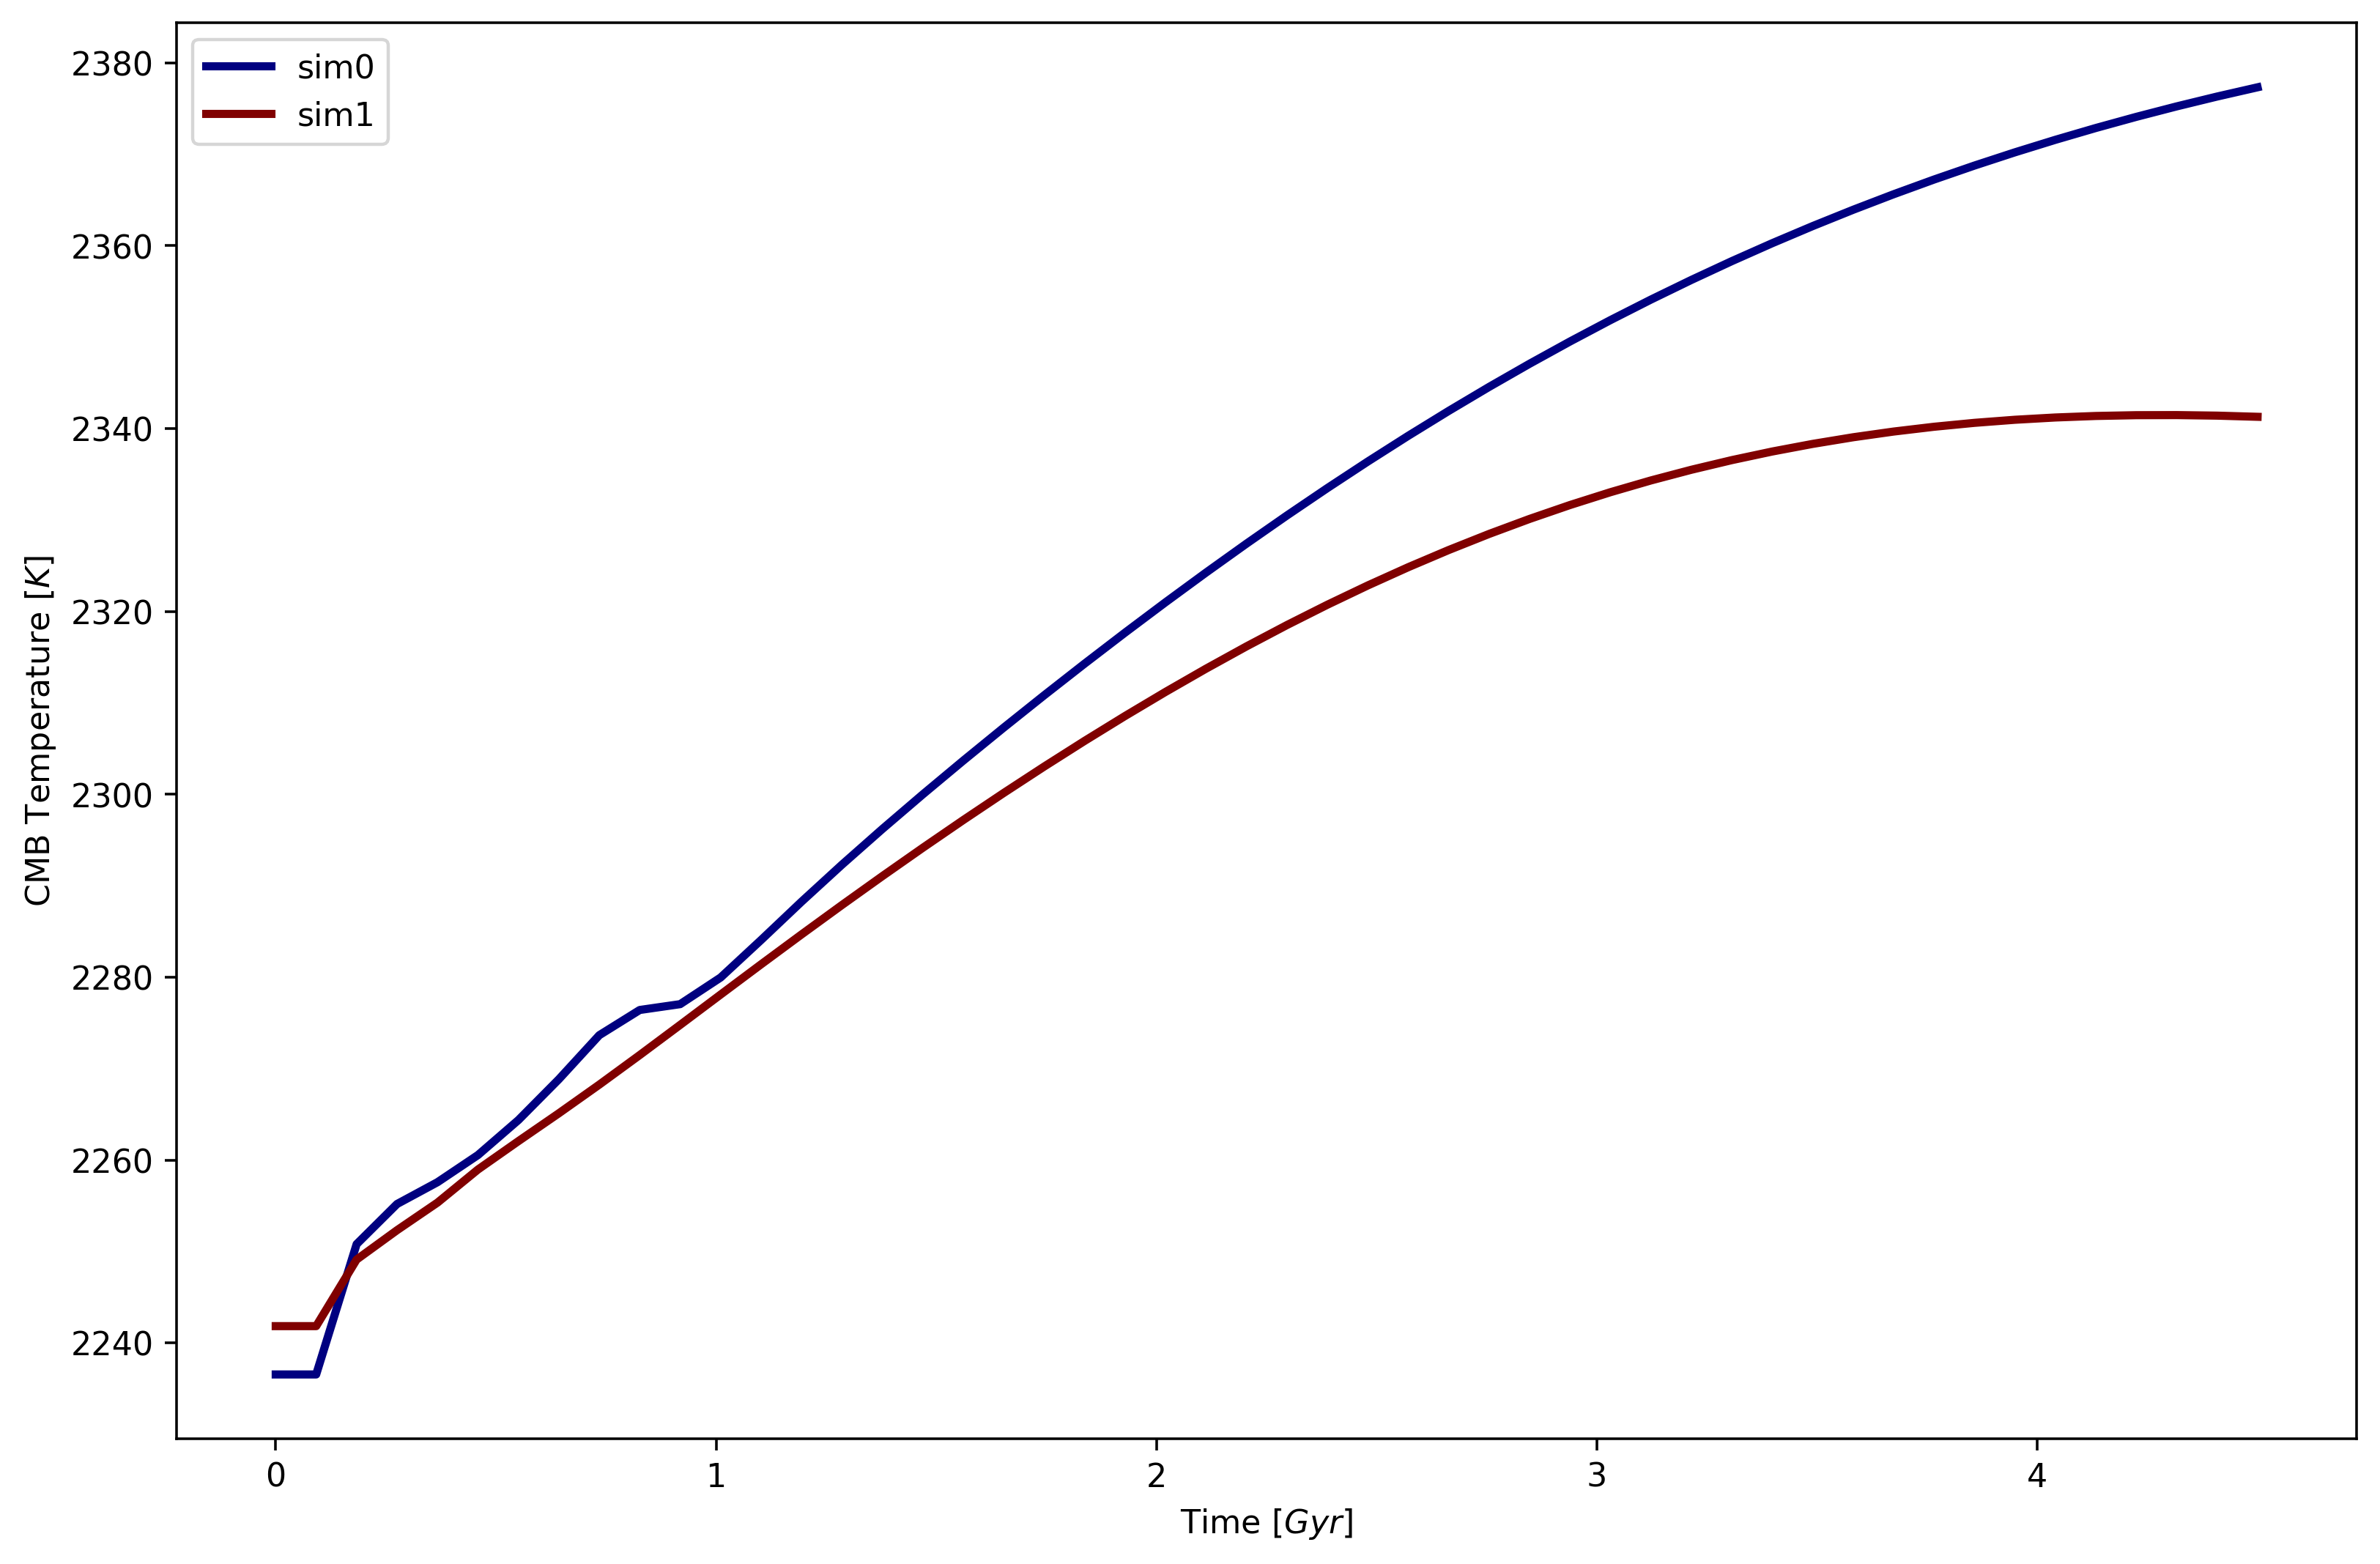

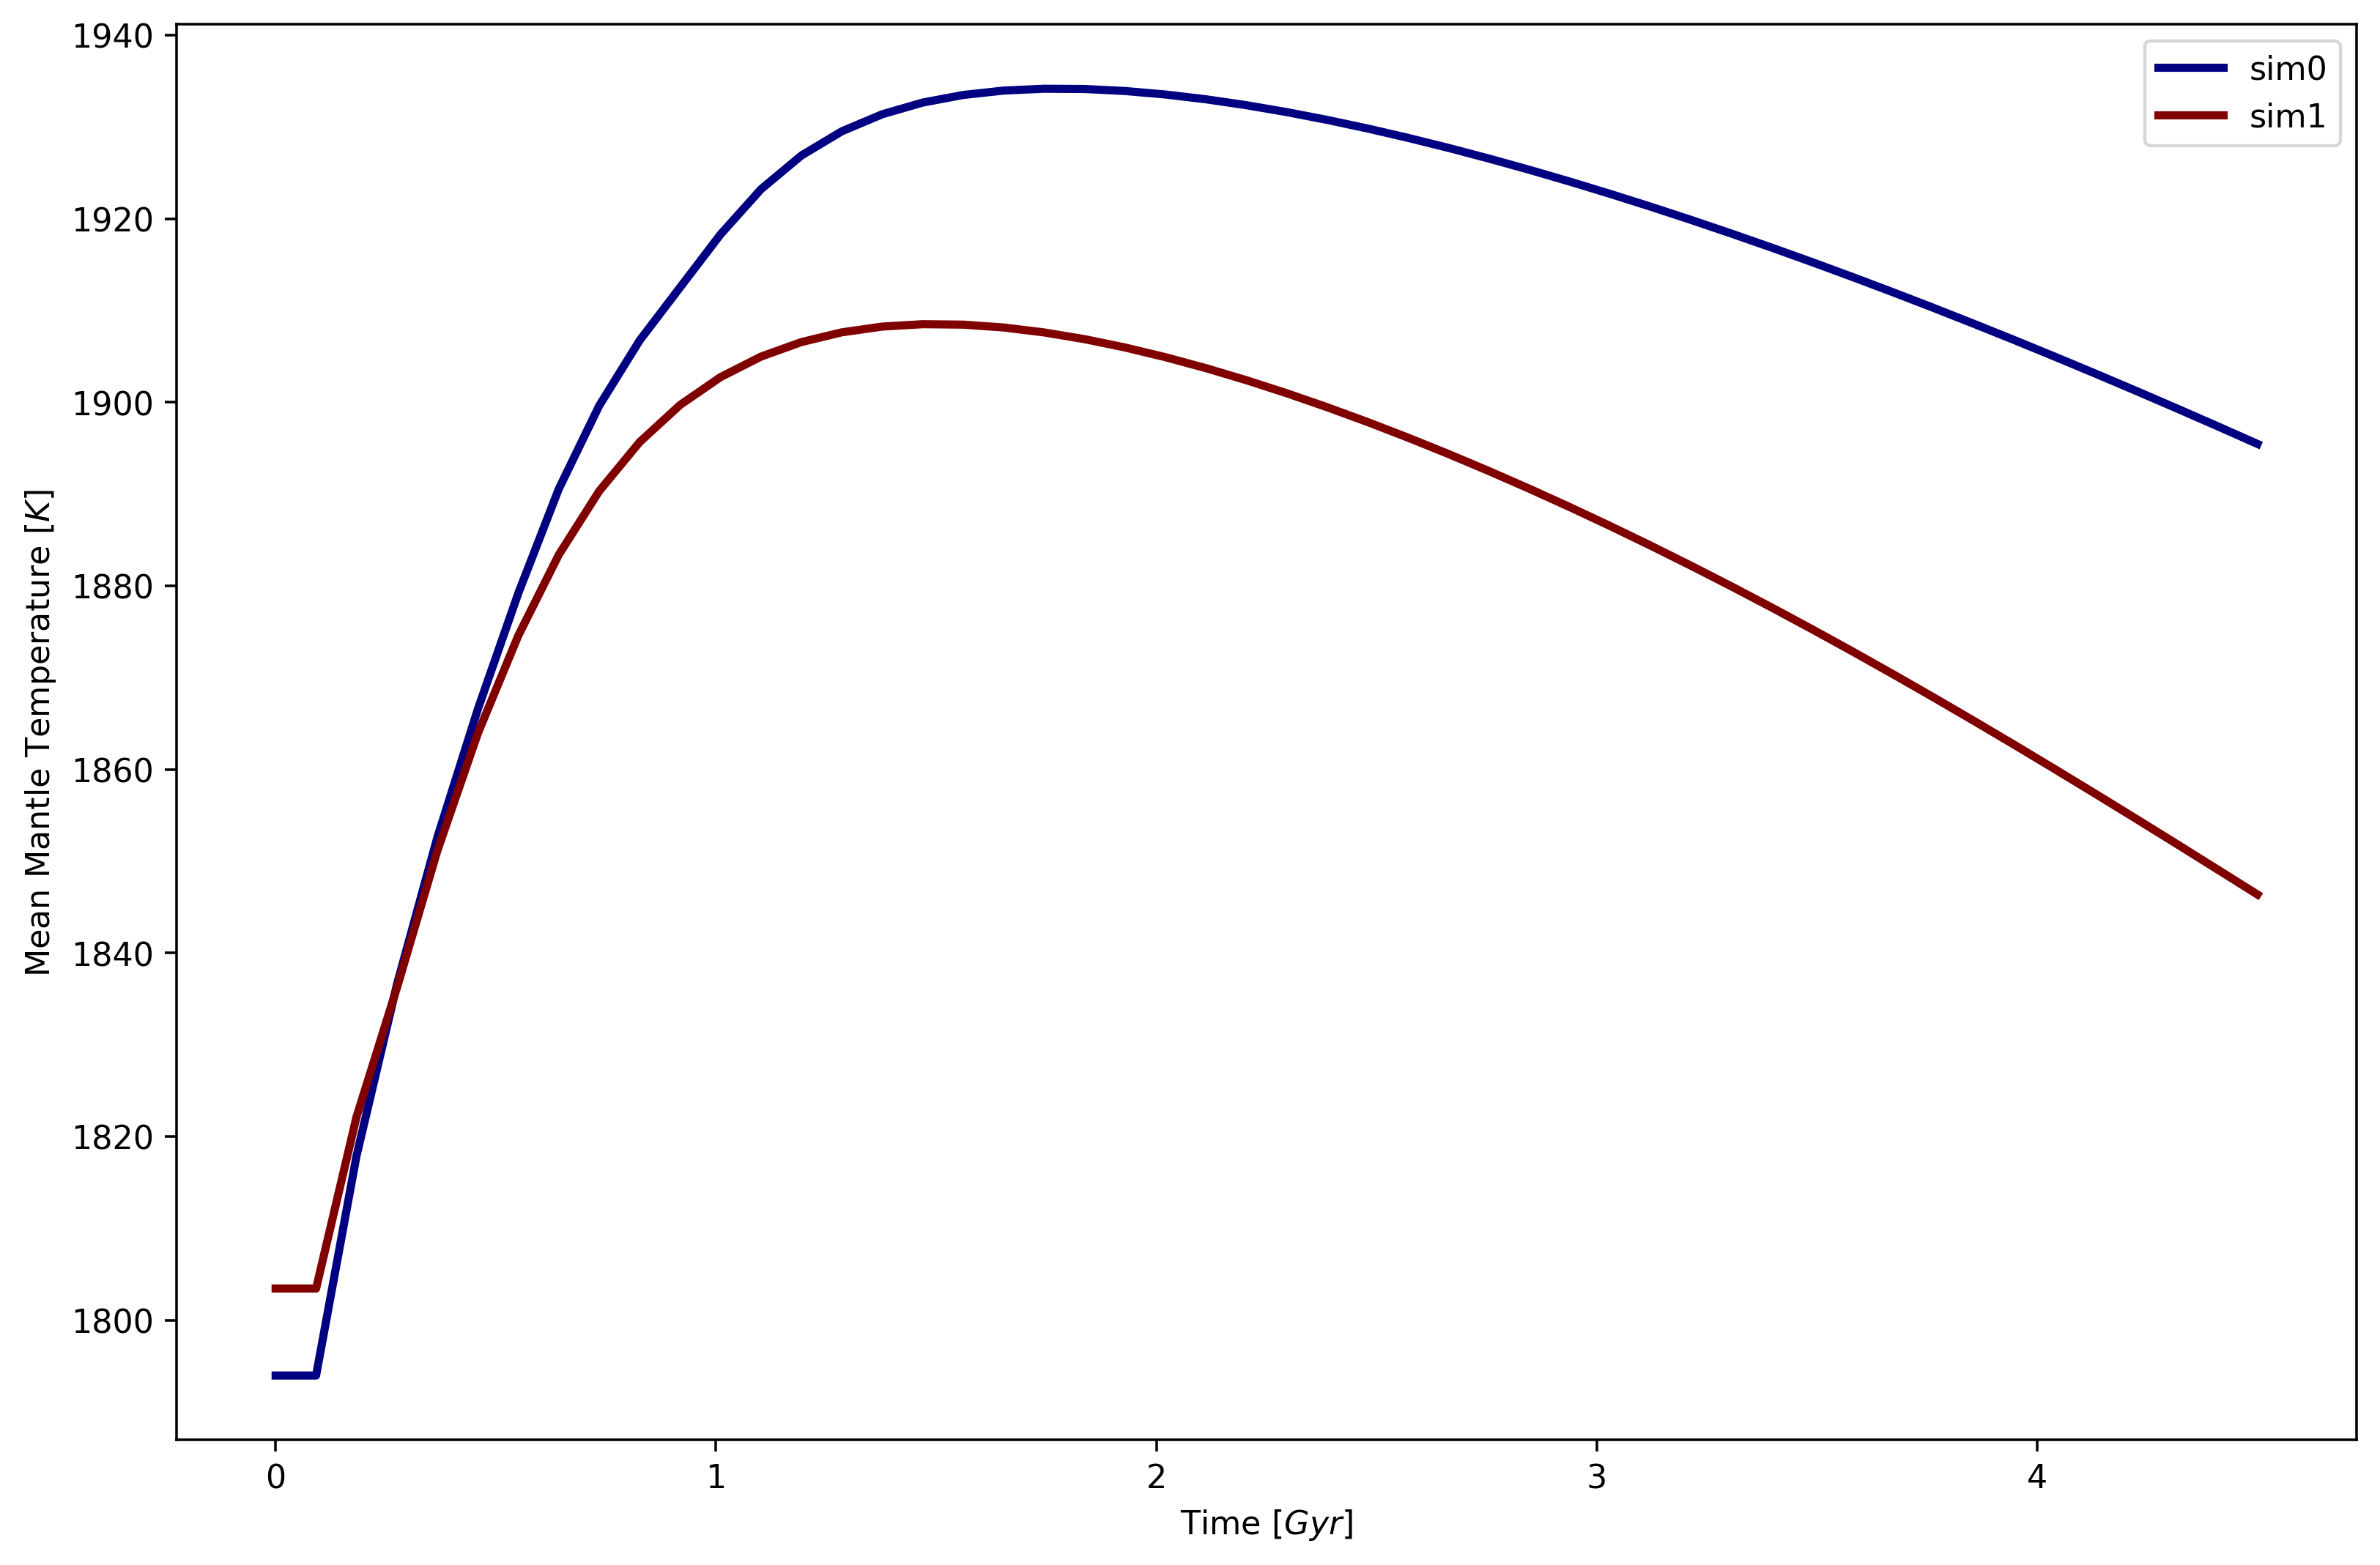

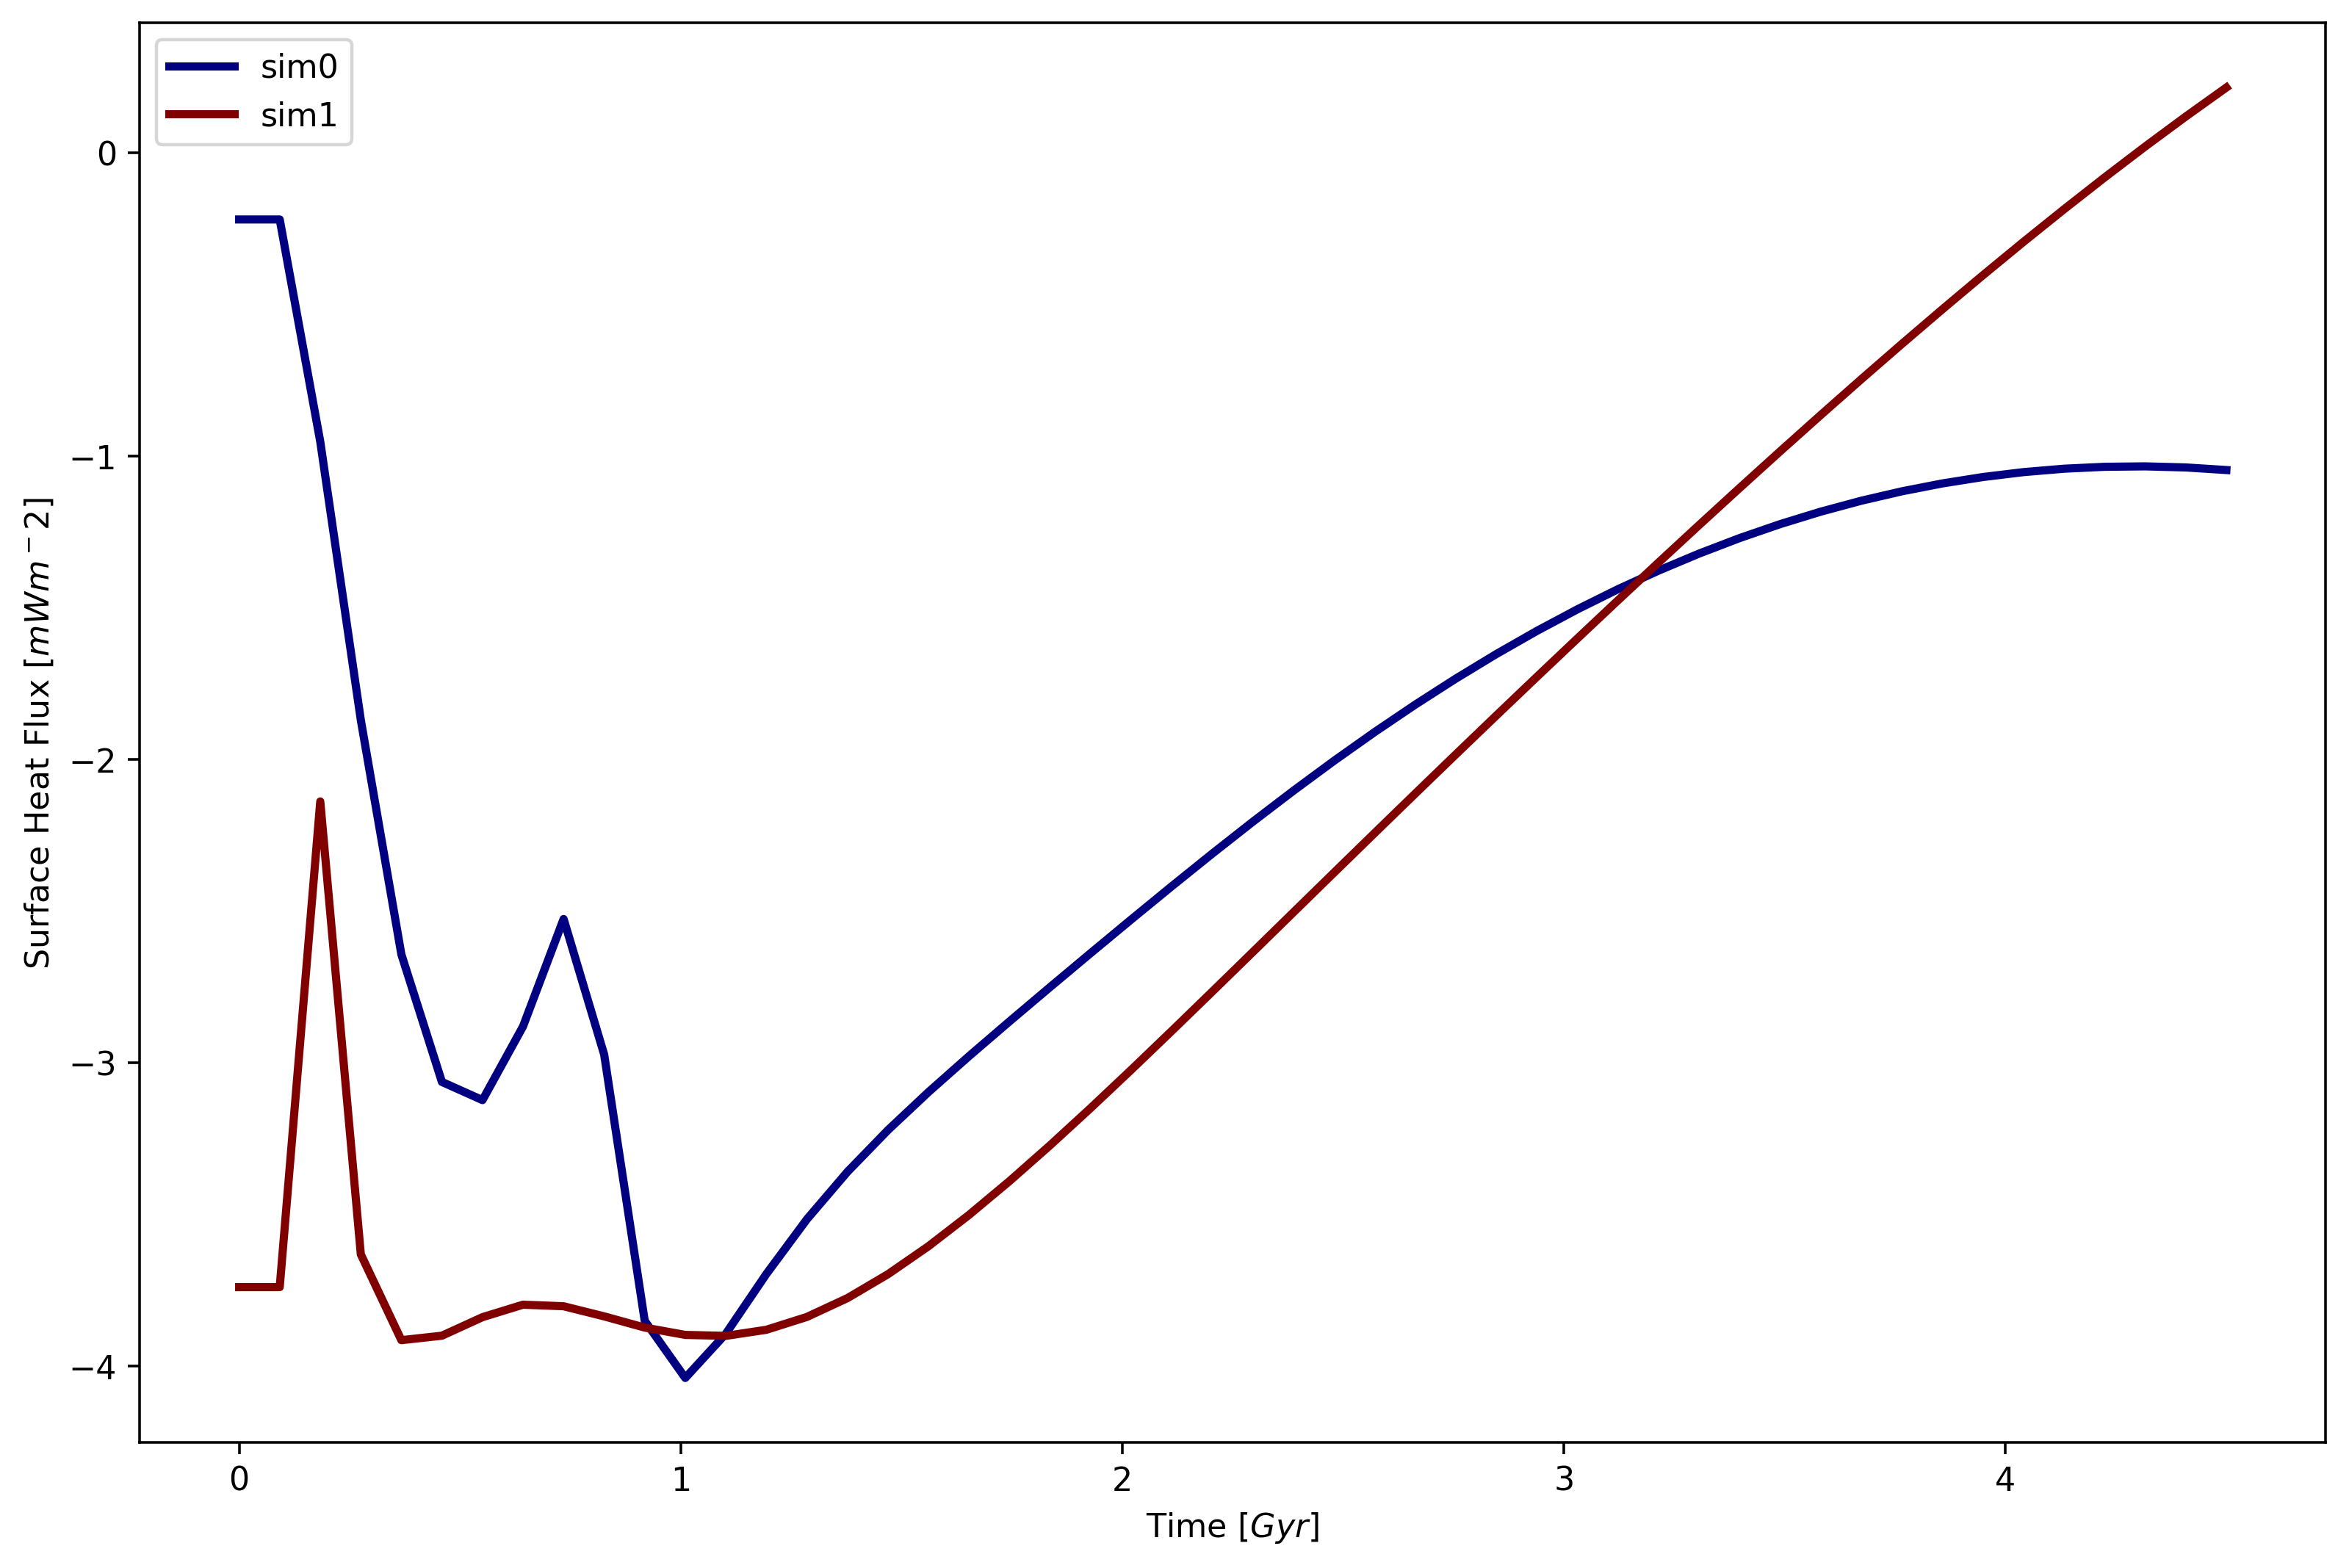

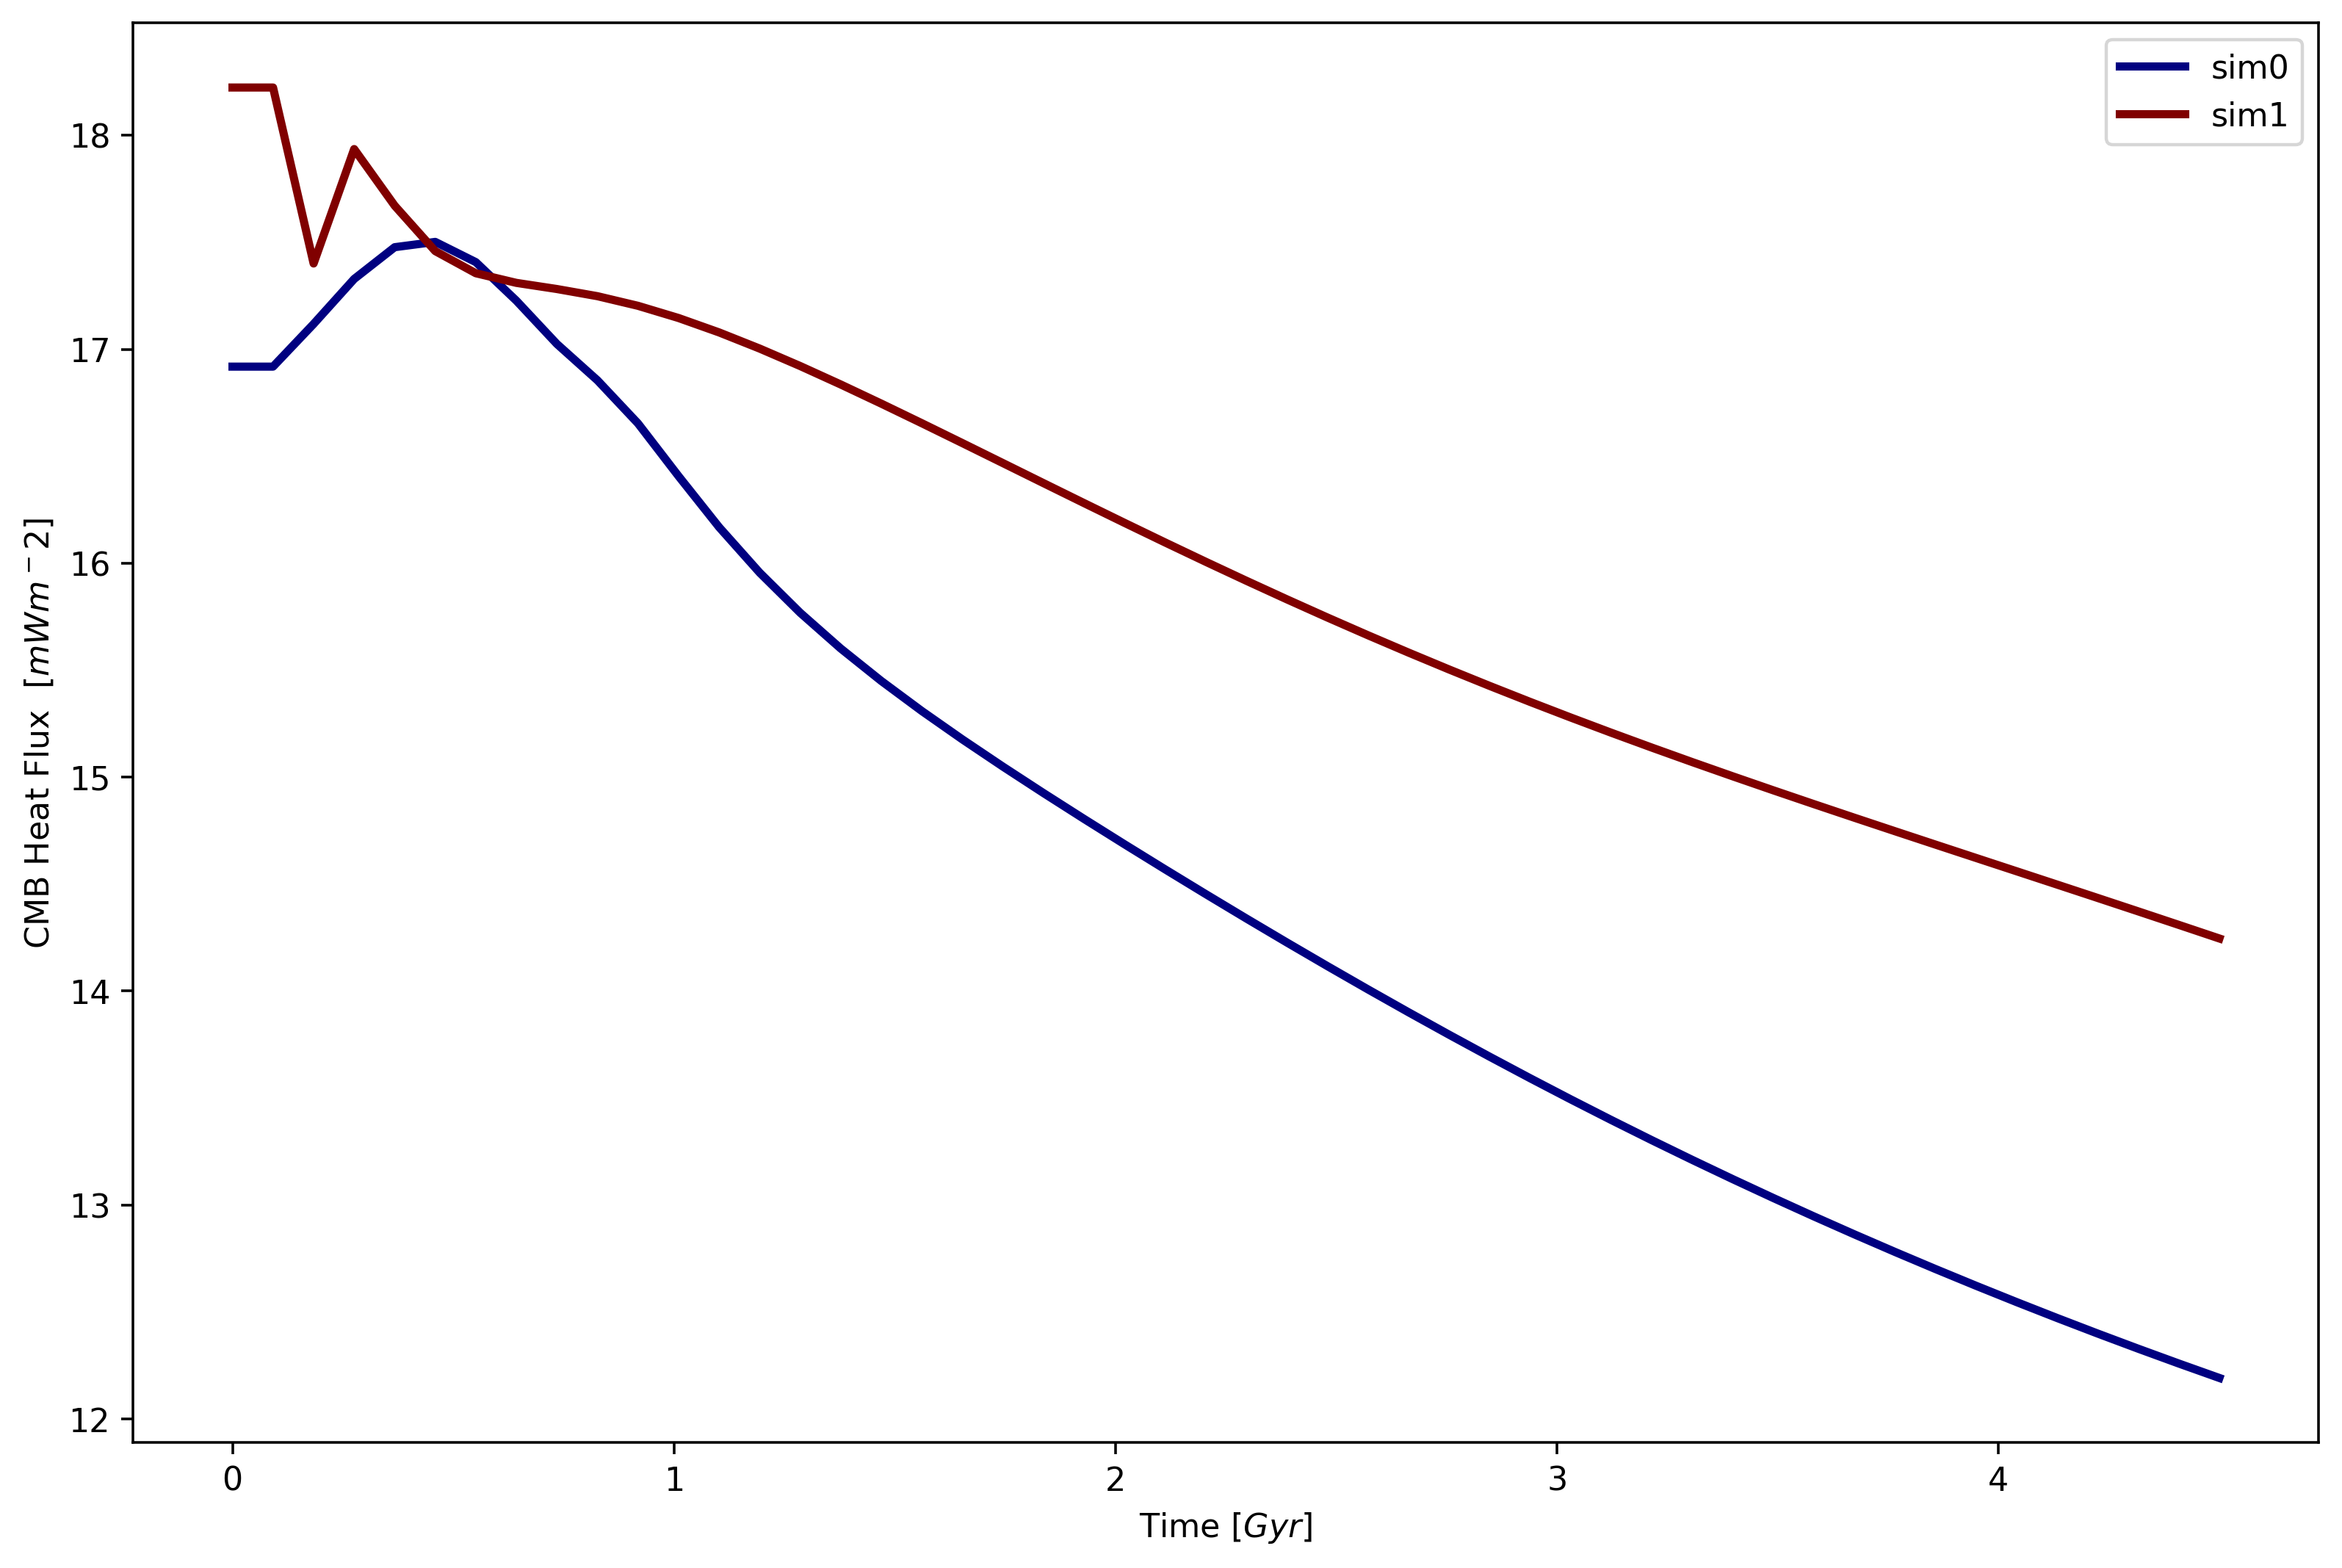

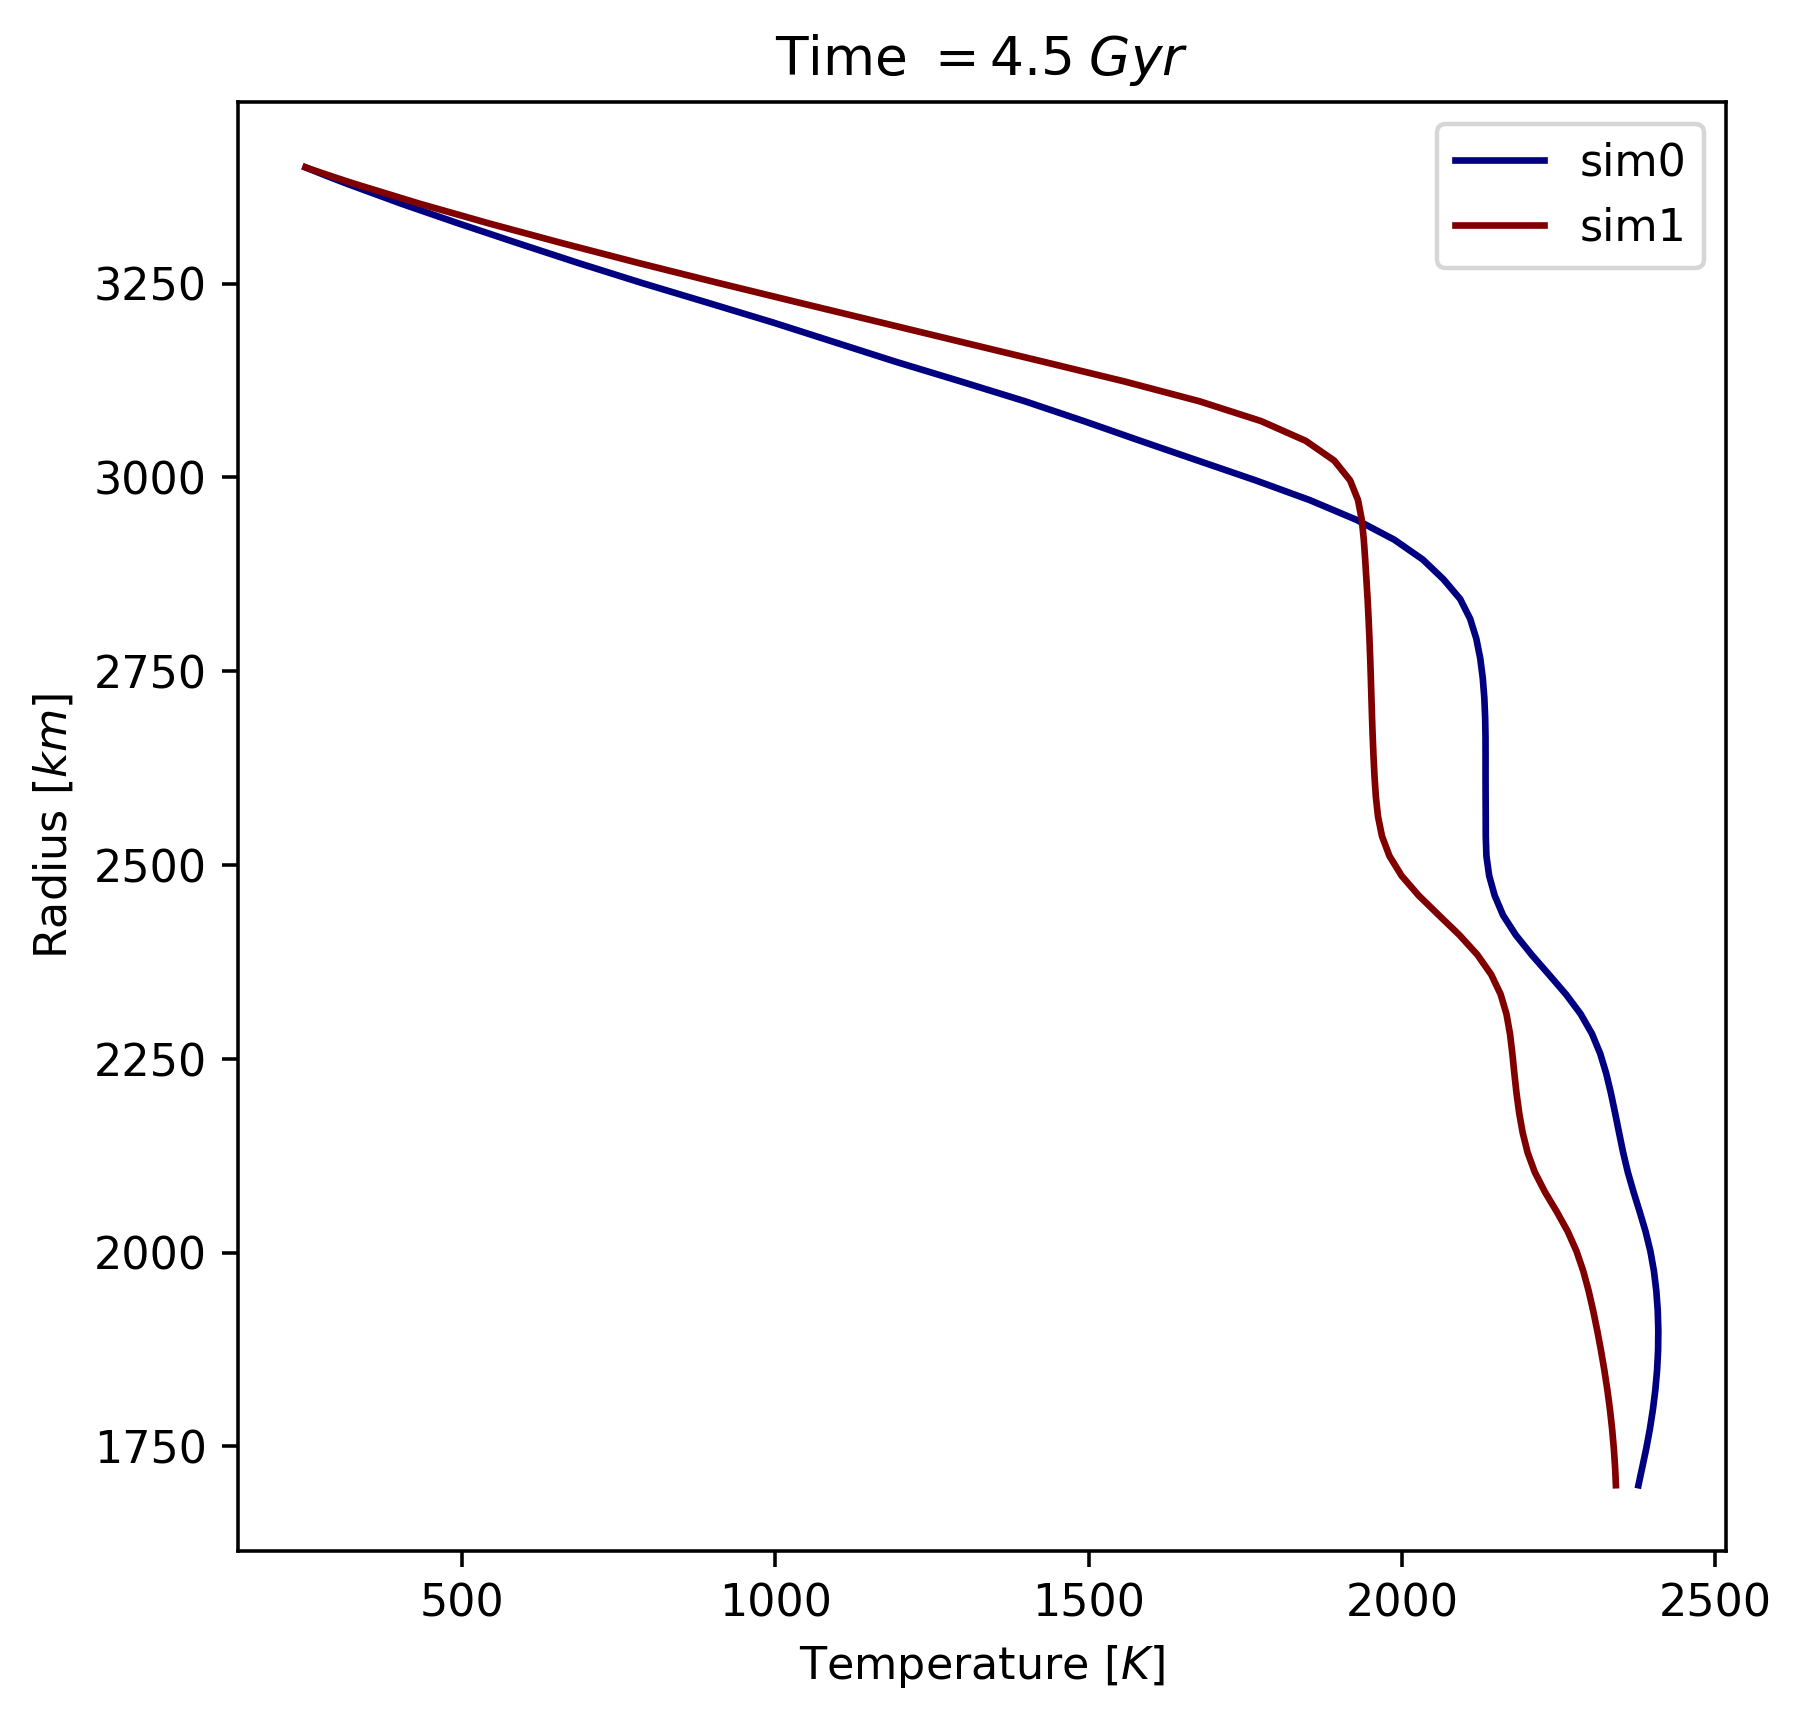

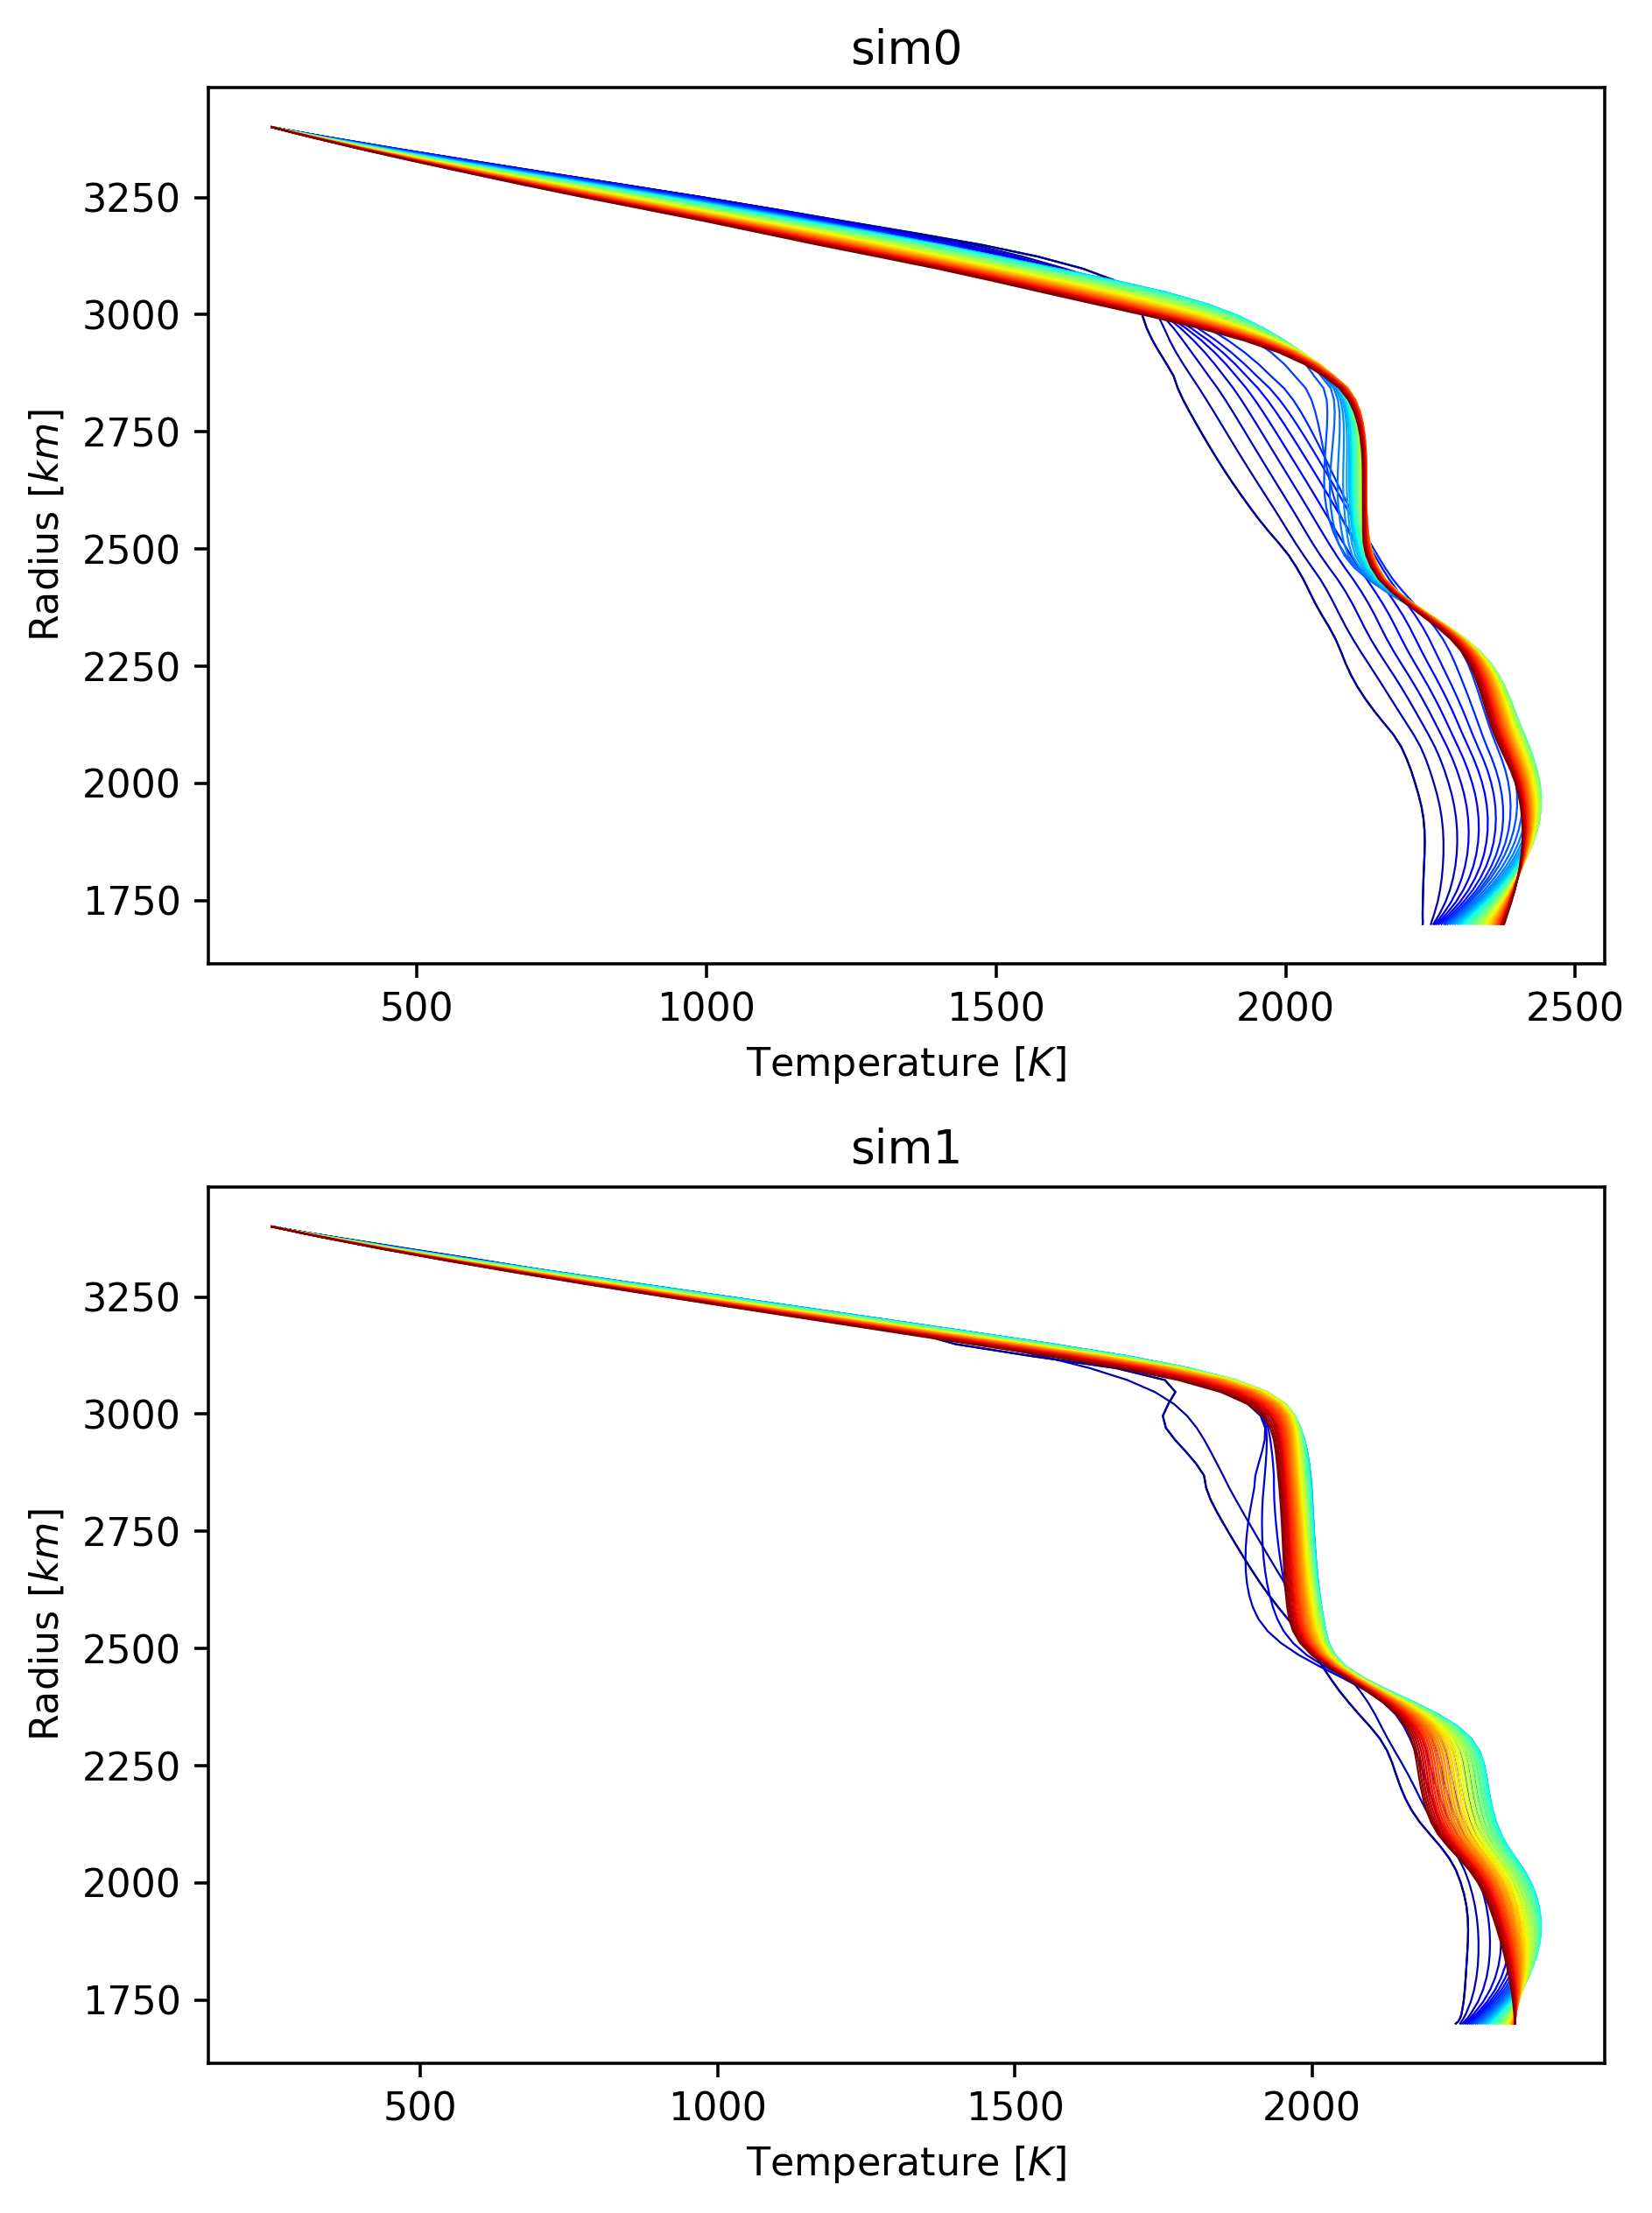

----------------------------------------------------------------------------------------------------


In [41]:
parameters = []
#  Ra, Eref, Vref, Enrichment, initial Temperature
parameters.append([318116.75, 12.0279, 7.94383, 20.0, 0.725])
parameters.append([3181167.5, 12.0279, 7.94383, 20.0, 0.725])

R = Regression([90,60,30])
R.NN(parameters, 10, 0.0001, 1.) 